# Computer Vison: Line Extraction

There exists a lot of methods allowing the detection of the edges of an image. In this work, we describe several of these methods. We explain how they works and show the influence of their hyperparameters. We show that well-chosen parameters allow to extract edges on images sharing the same properties. After some processing, we thus generate black-and-white images where the wite pixels represents the edges.

From these new images, we finally aim at finding the edges that are on straight lines. We have explored the Hough transform in its deterministic and probabilistic variants. We show that, once again, using the good hyperparameters for the methods, it is possible to extract the equations of the edges that are on straight lines.

Finally, using a pixel-classifier, we detect which edgdes of the original image are on lines.


In [1]:
import cv2
import numpy as np
import tools
import matplotlib.cm as cm   
from ipywidgets import interact, fixed

from image import *
from edge import *
from line import *

from notebook_utils import *

## Image preprocessing

Before applying edge detection, 3 optional operations could be performed:

* **low-pass filter**
A low pass filter can be applied in order to remove noise. We consider 3 types of filter: uniform bluring, gaussian bluring and median bluring. Each of these method's parameter is the size of the kernel.

* **high-pass filter**
A high pass filter could also be applied to sharpen the edges. The high pass filter is implemented the following way. First a low pass filter is applied. The high passed image is : 
$$
strength * image - (strength - 1.0) * low\_passed\_image
$$
The parameters are thus the same than for the low pass with an additional argument: strength.

* **thresholding**
Thresholding consists in giving to each pixel one extreme value of intensity. The first idea would be to fix a threshold based on the average intensity over the picture. We then set the value of each pixel to the maximal or minimal value depending on if this pixel has a higher or lower intensity compared to the average. A better solution is to compute the average over a smaller window compared to the image. In this case, the average is computed using a Gaussian mean.


## Edges Detection

As explained earlier, we applied different methods allowing to extract the pixels located on an edge. Simply using these methods does not show good performances. Image pre and post-precessing is needed, in addition of fine-tuning the hyperparameters of these methods. For each method, we also added the possibility to add a thresholding operation at the end that allow the removal of weak edges and of the remainding noise. We also put the value of the edges' pixels to pure white.

Let's first describe the working of the different methods we used:
* **Naive Gradient**
    This method consists in applying a liner filter computing the partial derivate of the image in each pixel according to the a central finite difference. It basically consists in computing the difference of the two neighbouring pixels for axis. The gradient is then computed as the average of the absolute value of the gradients in the two directions.
    
* **Laplacian**
source: https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html?highlight=laplacian#laplacian
This method consists in applying a linear filter computing the Laplacien using central finite difference to compute derivatives. The filter used is therefore the following:
$$
\begin{bmatrix}
0 & 1 & 0\\
1 & -4 & 1\\
0 & 1 & 0
\end{bmatrix}
$$
The size of this kernel can be increased as long as it stays of the same shape.

* **Sobel Gradient** 
Source: https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html
Sobel combines Gaussian smoothing and differentiation. Two kernels are applied to get derivative in two directions:
$$
\begin{bmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
1 & 2 & 1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$
The mean of the absolute value of the results of the application of those 2 kernels is then computed. The size of the kernel can also be increased.

* **Scharr Gradient**
Source: https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/sobel_derivatives/sobel_derivatives.html
Scharr works the same way as sobel but with the following kernels:
$$
\begin{bmatrix}
3 & 0 & -3\\
10 & 0 & -10\\
3 & 0 & -3
\end{bmatrix}
\begin{bmatrix}
3 & 10 & 3\\
0 & 0 & 0\\
-3 & -10 & -3
\end{bmatrix}
$$

* **Beucher**
The Beucher gradient (also called Morphological gradient) is the diference between the erosion and the dilation of an image. The erosion of A by B is defined by the union of the translations of B that are fully inside A. The dilation of A by B is the union of the translations of B whose center is inside A. Substracting the 2 only leave use with the edges of the image. 
The only parameter for this method is the size of the kernel (the B object) used for the dilation and the erosion. We could also modify the shape of this kernel, but we didn't find major differences between the shapes, so we used a simple square kernel.

* **Canny**
In the Canny algorithm, the gradients are first computed using the Sobel operator. If the gradient is superior to the high threshold, the pixel is classified as strong edge, if the gradient is between the low and high threshold, the pixel is classified as a weak edge, else it is not classified as an edge. Strong edges are always kept in the final edges. Weak edges are only kept in they are part of a blob of edges containing at least one strong edge. A blob of edges is defined as an ensemble of 8-connected edges. The other parameter of this method is the size of Sobel's kernel used.

* **Stacking** 
Stacking is inspired from machine learning where several models are use together in order to improve performance. All the above method can be seen as classifier classifying each pixel as being an edge or not. The stacking method classify a pixel if a sufficient amount of method classify this pixel as an edge. In the following, we only used sobel, naive gradient, scharr and beucher in the stacking as these methods have shown to have good results.

We then tuned the parameters of the pre-processing and of the edges detection methods. We only tuned the parameters images for the sudokus and the building image classes. The following tool allows to visualize the impact of the variations of parameters. The tuning has had to be done "by eye", since there is no mathematical performance metric that we can use.

In [2]:
ui, out = build_ui_edges()
display(ui, out)

Output()

### Building edges

Here are the edges extracted from the images with the tuned parameters.

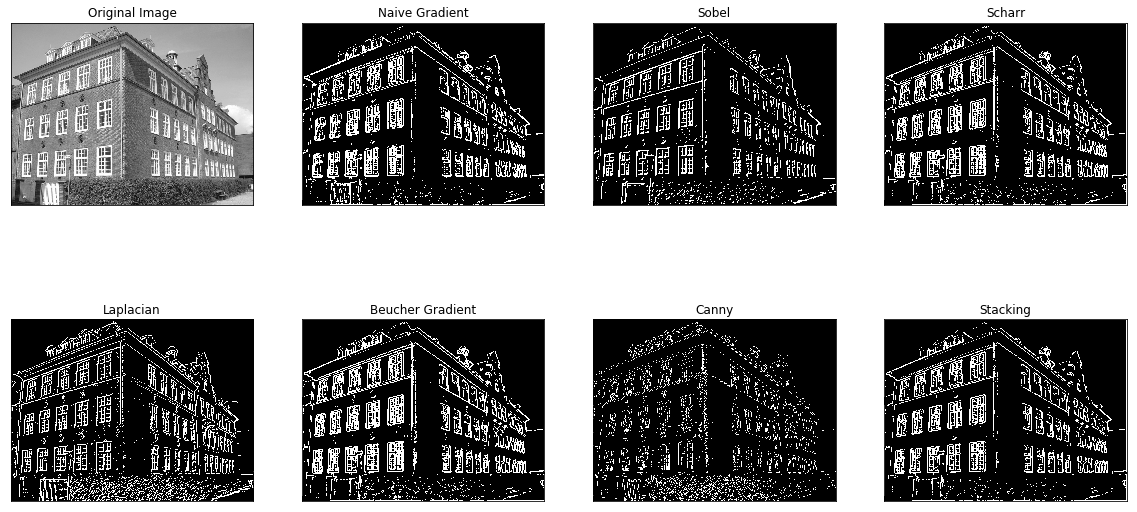

In [3]:
img = load_gray_img("img/building.png")

naive_grad = get_optimal_grads("building", "building", "Naive Gradient")
sobel_grad = get_optimal_grads("building", "building", "Sobel")
scharr_grad = get_optimal_grads("building", "building", "Scharr")
canny_grad = get_optimal_grads("building", "building", "Canny")
beucher_grad = get_optimal_grads("building", "building", "Beucher")
stacking_grad = get_optimal_grads("building", "building", "Stacking")
laplacian_grad = get_optimal_grads("building", "building", "Laplacian")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, laplacian_grad, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Laplacian', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

Sobel is the method that lead to the best results, we therefore evaluate this method with the same parameters on other images. Evaluating the method on images the parameters were not tuned for allows to see how well the method generalizes.

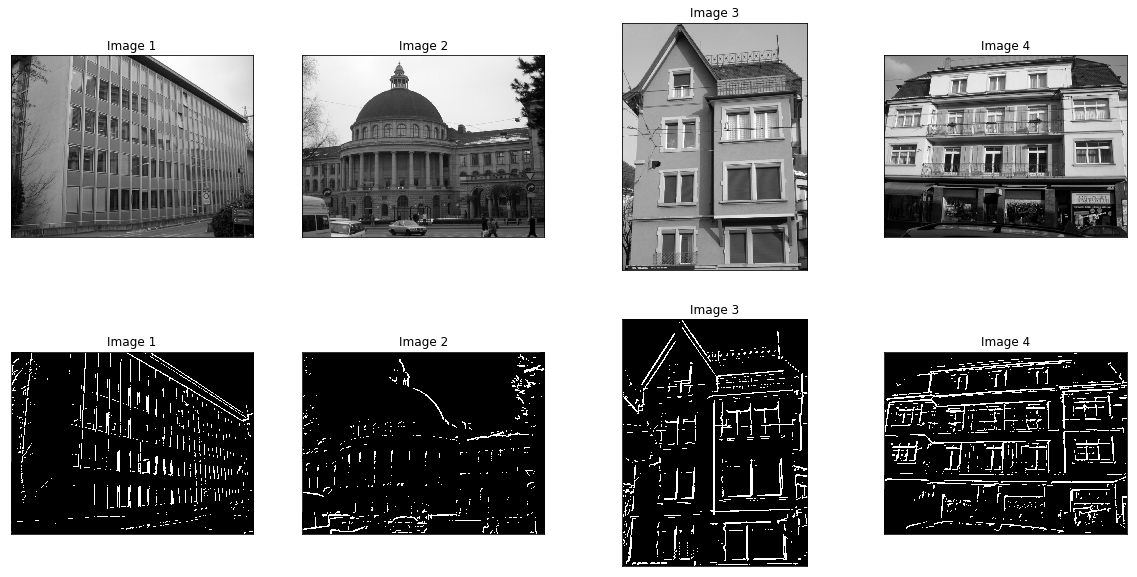

In [4]:
img_1 = load_gray_img("img/building_1.png")
img_2 = load_gray_img("img/building_2.png")
img_3 = load_gray_img("img/building_3.png")
img_4 = load_gray_img("img/building_4.png")

grad_1 = get_optimal_grads("building_1", "building", "Sobel")
grad_2 = get_optimal_grads("building_2", "building", "Sobel")
grad_3 = get_optimal_grads("building_3", "building", "Sobel")
grad_4 = get_optimal_grads("building_4", "building", "Sobel")

tools.multiPlot(2, 4, 
        (img_1, img_2, img_3, img_4, grad_1, grad_2, grad_3, grad_4),
        ('Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 1', 'Image 2', 'Image 3', 'Image 4'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

### Sudoku edges

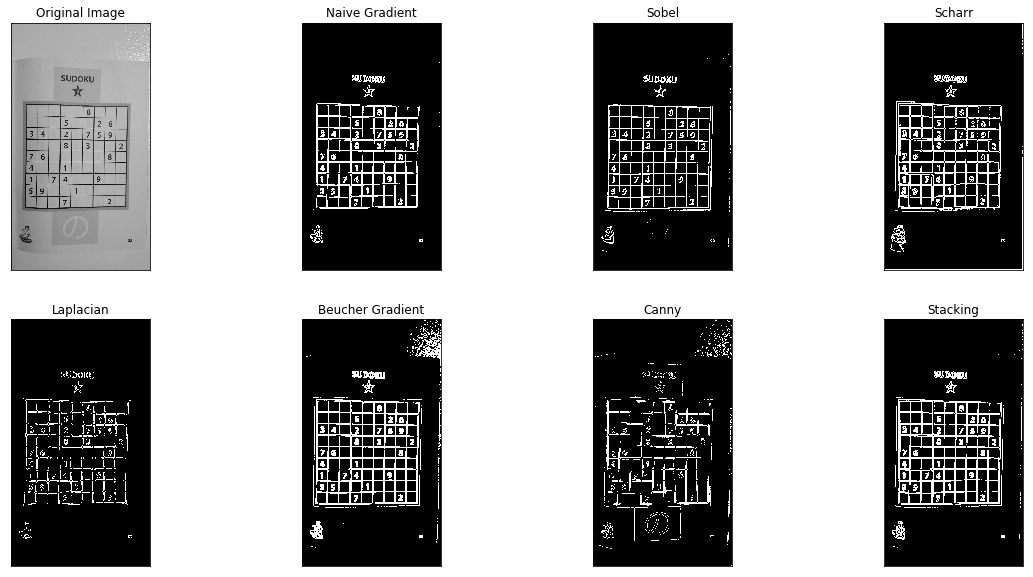

In [5]:
img = load_gray_img("img/sudoku.png")

naive_grad = get_optimal_grads("sudoku", "sudoku", "Naive Gradient")
sobel_grad = get_optimal_grads("sudoku", "sudoku", "Sobel")
scharr_grad = get_optimal_grads("sudoku", "sudoku", "Scharr")
canny_grad = get_optimal_grads("sudoku", "sudoku", "Canny")
beucher_grad = get_optimal_grads("sudoku", "sudoku", "Beucher")
stacking_grad = get_optimal_grads("sudoku", "sudoku", "Stacking")
laplacian_grad = get_optimal_grads("sudoku", "sudoku", "Laplacian")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, laplacian_grad, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Laplacian', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

Test on other images.

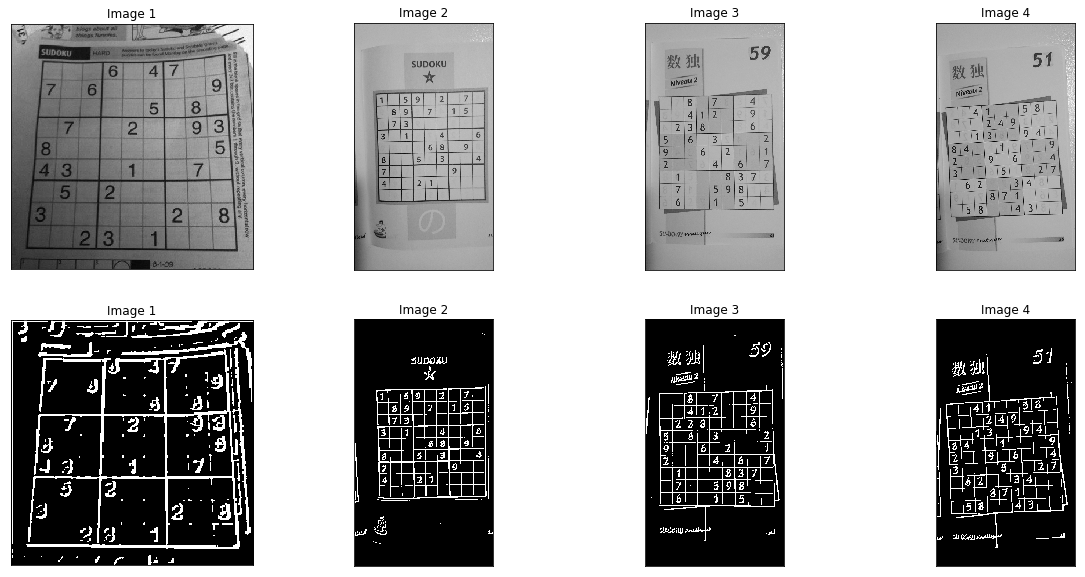

In [6]:
img_1 = load_gray_img("img/sudoku_1.png")
img_2 = load_gray_img("img/sudoku_2.png")
img_3 = load_gray_img("img/sudoku_3.png")
img_4 = load_gray_img("img/sudoku_4.png")

grad_1 = get_optimal_grads("sudoku_1", "sudoku", "Sobel")
grad_2 = get_optimal_grads("sudoku_2", "sudoku", "Sobel")
grad_3 = get_optimal_grads("sudoku_3", "sudoku", "Sobel")
grad_4 = get_optimal_grads("sudoku_4", "sudoku", "Sobel")

tools.multiPlot(2, 4, 
        (img_1, img_2, img_3, img_4, grad_1, grad_2, grad_3, grad_4),
        ('Image 1', 'Image 2', 'Image 3', 'Image 4', 'Image 1', 'Image 2', 'Image 3', 'Image 4'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

## Soccer Edge

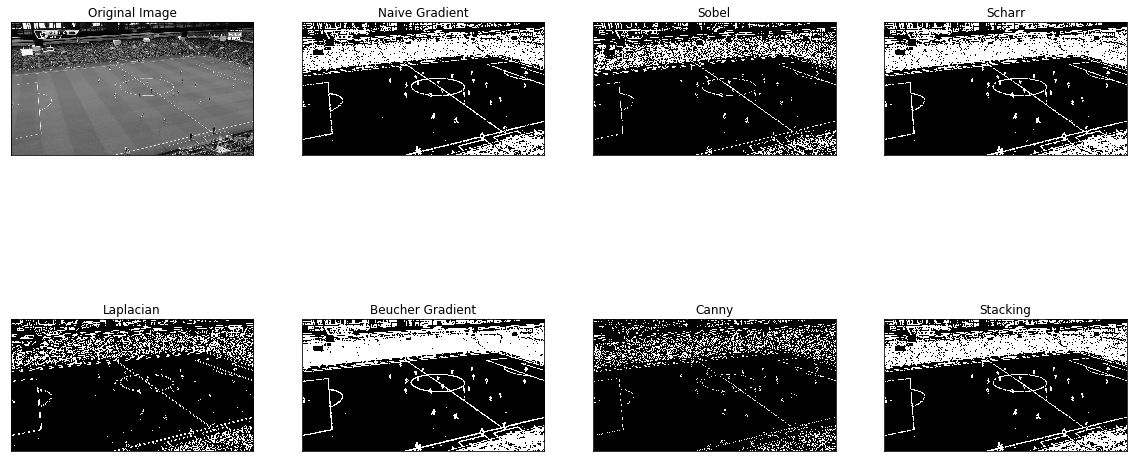

In [7]:
img = load_gray_img("img/soccer.png")

naive_grad = get_optimal_grads("soccer", "soccer", "Naive Gradient")
sobel_grad = get_optimal_grads("soccer", "soccer", "Sobel")
scharr_grad = get_optimal_grads("soccer", "soccer", "Scharr")
canny_grad = get_optimal_grads("soccer", "soccer", "Canny")
beucher_grad = get_optimal_grads("soccer", "soccer", "Beucher")
stacking_grad = get_optimal_grads("soccer", "soccer", "Stacking")
laplacian_grad = get_optimal_grads("soccer", "soccer", "Laplacian")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, laplacian_grad, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Laplacian', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

### Other classes of images

We here show the results obtained on the two remaining classes of image. Note that parameters have not been tuned for those classes.

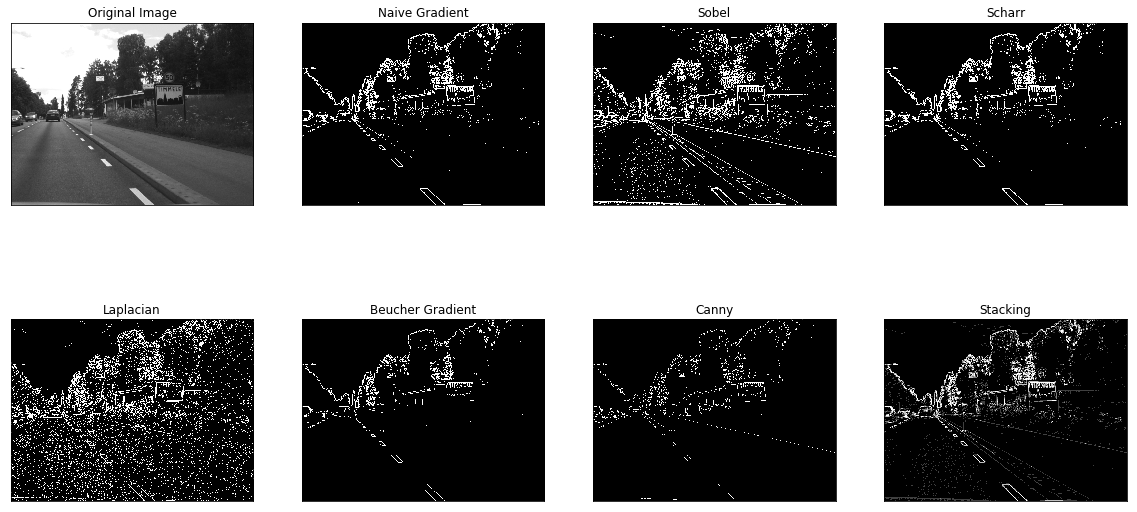

In [8]:
img = load_gray_img("img/road.png")

naive_grad = get_optimal_grads("road", "road", "Naive Gradient")
sobel_grad = get_optimal_grads("road", "road", "Sobel")
scharr_grad = get_optimal_grads("road", "road", "Scharr")
canny_grad = get_optimal_grads("road", "road", "Canny")
beucher_grad = get_optimal_grads("road", "road", "Beucher")
stacking_grad = get_optimal_grads("road", "road", "Stacking")
laplacian_grad = get_optimal_grads("road", "road", "Laplacian")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, laplacian_grad, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Laplacian', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

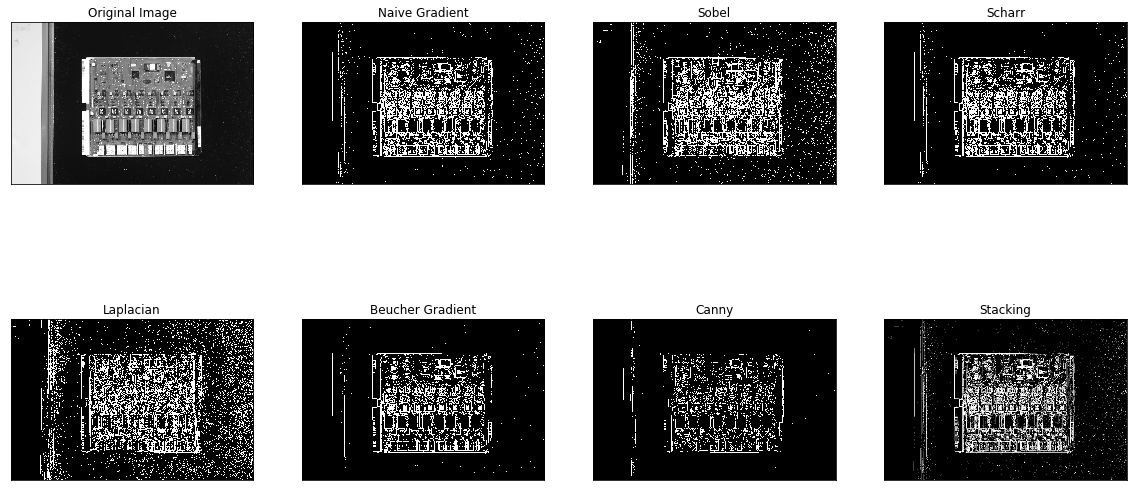

In [9]:
img = load_gray_img("img/pcb.png")

naive_grad = get_optimal_grads("pcb", "pcb", "Naive Gradient")
sobel_grad = get_optimal_grads("pcb", "pcb", "Sobel")
scharr_grad = get_optimal_grads("pcb", "pcb", "Scharr")
canny_grad = get_optimal_grads("pcb", "pcb", "Canny")
beucher_grad = get_optimal_grads("pcb", "pcb", "Beucher")
stacking_grad = get_optimal_grads("pcb", "pcb", "Stacking")
laplacian_grad = get_optimal_grads("pcb", "pcb", "Laplacian")

tools.multiPlot(2, 4, 
        (img, naive_grad, sobel_grad, scharr_grad, laplacian_grad, beucher_grad, canny_grad, stacking_grad),
        ('Original Image', 'Naive Gradient', 'Sobel', 'Scharr', 'Laplacian', 'Beucher Gradient', 'Canny', 'Stacking'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray, cm.gray))

## Edges Detection Using Contour Detection

Contour following algorithms are a class of method allowing to extract the contour of the different objects in an image. In opposition to edge detection, it uses the topology of the image and the objects to build the frontier between the object and the background scene. The algorithm used in the following code builds the frontier dynamically by following the pixels considered as part of the frontier.

This method is thus an alternative way of extracting the edges of an image. 

In [10]:
ui, out = build_ui_edges("Following")
display(ui, out)

Output()

The method is based on two parameters. A lower and an upper threshold. The lower threshold defines a minimal intensity to apply the contour following algorithm. For a low threshold, lots of contours are detected. Most of them being irrelevant. The high threshold is the maximal intensity and shall be set to 255. 

Applying an additional Thresholding doesn't seems to increase much the performance. Neither does a preprocessing with high pass or low pass filtering. 

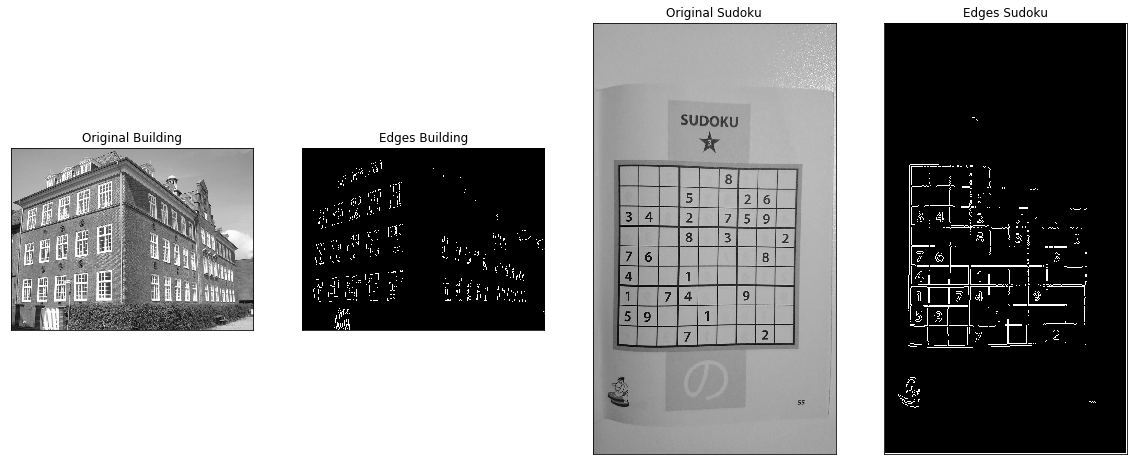

In [11]:
img_0 = load_gray_img("img/building.png")
img_1 = load_gray_img("img/sudoku.png")

edge_img_0 = get_optimal_grads("building", "building", "Following")
edge_img_1 = get_optimal_grads("sudoku", "sudoku", "Following")

tools.multiPlot(1, 4, 
        (img_0, edge_img_0, img_1, edge_img_1),
        ('Original Building', 'Edges Building', 'Original Sudoku', 'Edges Sudoku'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray))

On the building, having a high lower threshold of 240 results in the best performances. For the sudoku, the threshold of 45 yields the best contours. Let's nevertheless remark that none reaches performances as good as the previous methods. Also, the parameters are completely different for the two different images.

This method's first use is not te extract edges but more to detect the contour of objects in a scene. Even though these two tasks are very similar, they are not achieved using the same methods.


## Line Extraction

We have seen that the previous methods allow to extract an image where the pixels being on an edge are white and all others black. In particular, the Sobbel gradient yields the most accurate figure, and will be used for the rest of this work. From this image we aim at finding the pixels placed on a line. A method for achieving this result is to build the set of lines going through each white dot. If many lines share the same parametrization, they correspond to an edge where each pixels are on a same straight line. This method corresponds to the so-called Hough Line Transform.

The Hough Line Transform extracts a set of lines corresponding to the edges in a picture. Three main parameters influence the result of the transformation. First, the set of lines build from each pixel will never share the exact same parametrization even though they correspond to the same line. It is due to the inaccuracies in the image and its gradient transformation. Two tolerance parameters are thus used. The first corresponds to the error allowed in the direction of the lines, usually called rho. The second is the tolerance in radial coordinate, called theta. Finally, a threshold defines how many lines must share the same parametrization, to accept this parametrization to be consistent with an edge.

The Hough method has, nevertheless, a very annoying drawback. A line is extracted rather than a segment. It is thus difficult to extract the edges from this method and the number of points to accept the line is thus difficult to fix in order to take into account the length of the edges.

The Progressive Probabilistic Hough Transform is a variant of the previous method. It consists in sampling random points and looking at the possibility for them to be due to noise. This is repeated taking into account a minimal length and a number of positive votes necessary. A maximal gap between pixels on a line is also considered. This method is implemented and allows to detect the extrema points of the lines. 


### Hough Line Transform

In [12]:
interact(lambda image, rho, theta, threshold: hough_determinist_print(get_optimal_grads(image, image, "Sobel"),
                                                                      load_gray_img("img/%s.png" % image),
                                                                      rho, 
                                                                      theta, 
                                                                      threshold), 
         image = ["building", "sudoku", "soccer", "road", "pcb"],
         rho = (1, 10, 1), 
         theta = (np.pi / 360, np.pi / 90, np.pi / 1440), 
         threshold = (200, 400, 20))
pass

interactive(children=(Dropdown(description='image', options=('building', 'sudoku', 'soccer', 'road', 'pcb'), v…

For the building, a small rho is preferred. It strongly reduces the irrelevant edges. Since all the edges are directed in three main directions, a large theta can be used. It thus states that high errors are allowed. Let's remark that there is a tradeoff between reject the noisy points, and the detection of all the lines in the image. The method detects many irrelevant lines. Choosing a value around 0.03 yields good results. In order to reject them, a large threshold can be chosen, 360 is a good trade-off. It nevertheless results in ignoring many edges. 

For the sudoku, it is another story. The Sobel gradient image is much cleaner and lower threshold can be used. An angular error of 0.03 and a threshold of 200 yields excellent results.

This method is very image dependent. In the case of the clean sudoku image, the results are very good and quite insensitive to the hyperparameters. For the building, it performs poorly, and the parameters must be very well chosen to reach some good performance.


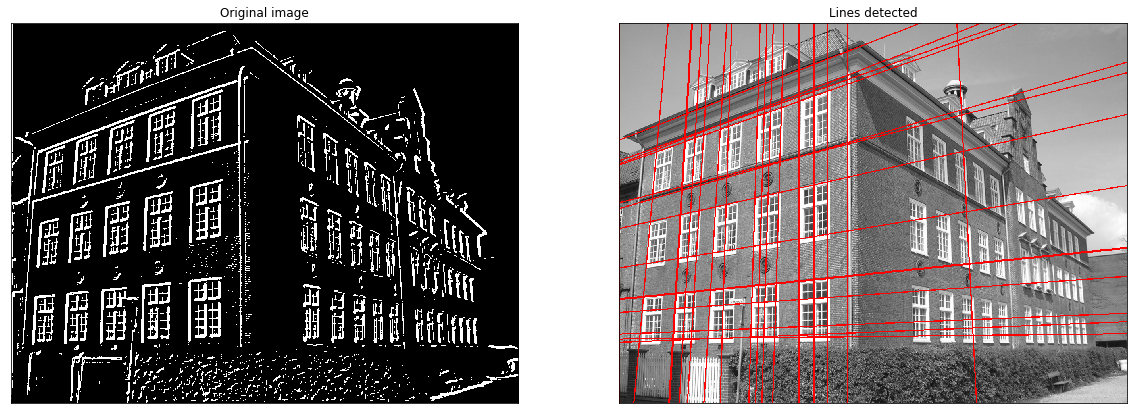

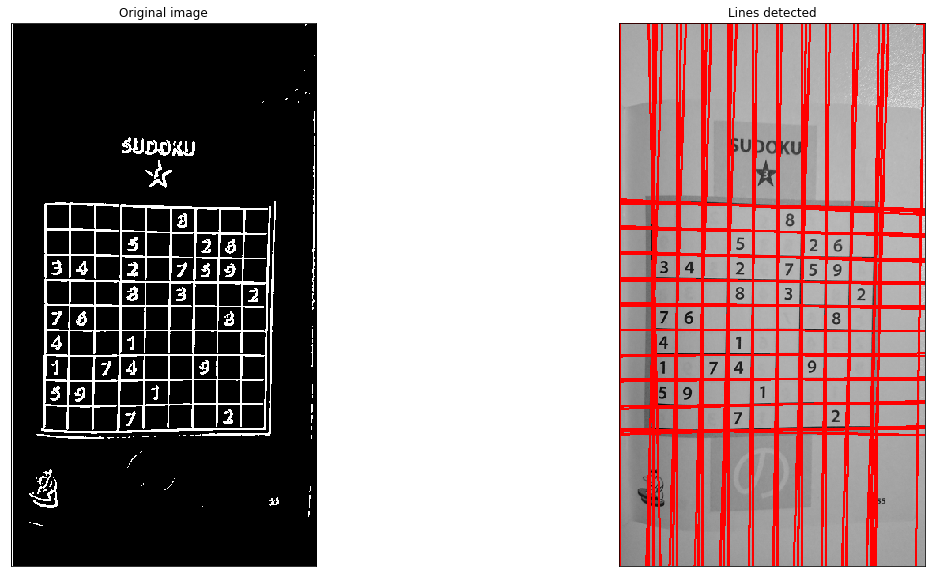

In [13]:
img_0 = load_gray_img("img/building.png")
img_1 = load_gray_img("img/sudoku.png", scale = 0.5)

edge_img_0 = get_optimal_grads("building", "building", "Sobel")
edge_img_1 = get_optimal_grads("sudoku", "sudoku", "Sobel")

hough_determinist_print(edge_img_0, img_0, 1, 0.03, 360)
hough_determinist_print(edge_img_1, img_1, 1, 0.015, 200)

### Progressive Probabilistic Hough Transform

In [14]:
interact(lambda image, rho, theta, threshold, minLineLength, maxLineGap: 
         hough_probabilist_print(get_optimal_grads(image, image, "Sobel"),
                                 load_gray_img("img/%s.png" % image),
                                 rho, 
                                 theta, 
                                 threshold,
                                 minLineLength,
                                 maxLineGap), 
         image = ["building", "sudoku", "soccer", "road", "pcb"],
         rho = (1, 10, 1), 
         theta = (np.pi / 360, np.pi / 90, np.pi / 1440), 
         threshold = (50, 150, 10),
         minLineLength = (30, 100, 5), 
         maxLineGap = (5, 50, 5))
pass

interactive(children=(Dropdown(description='image', options=('building', 'sudoku', 'soccer', 'road', 'pcb'), v…

First, for the building, keeping the same error as previously makes sense for the same reasons. The threshold is nevertheless chosen much smaller, 50 is a good trade-off. By choosing minimal length of 100 and a maximal gap between pixels of 5, we get quite good results.

On the sudoku, the same parameters works well too. There is, nevertheless, a little bit of noise. 

This method allows to extract the lines on the soccer dataset too. Using a larger angular tolerance, 0.03, a threshold of 80 and a minimal length of 110, we reach quite good results. These parameters are chosen to detect longer lines on the picture corresponding to the white lines. 

We observe that for the building this method is much more suitable compared to the previous. For the sudoku, where the lines are easy to extract, this method is more noisy, but also detect smaller lines in the numbers of the grid. The previous method did not work at all for the succer while the probabilitic version yields decent results. 

Let's remark that this method seems to yield quite good results when choosing a small minimal length for the edges. It results from the interpolation of a lot of very small edges. Doing so has as drawback not to yield one proper equation for each line. There is once again a trade off.

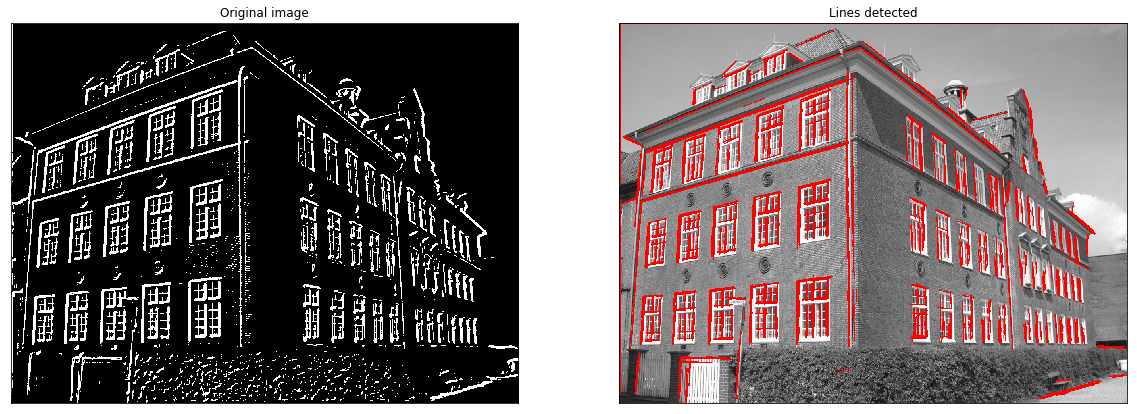

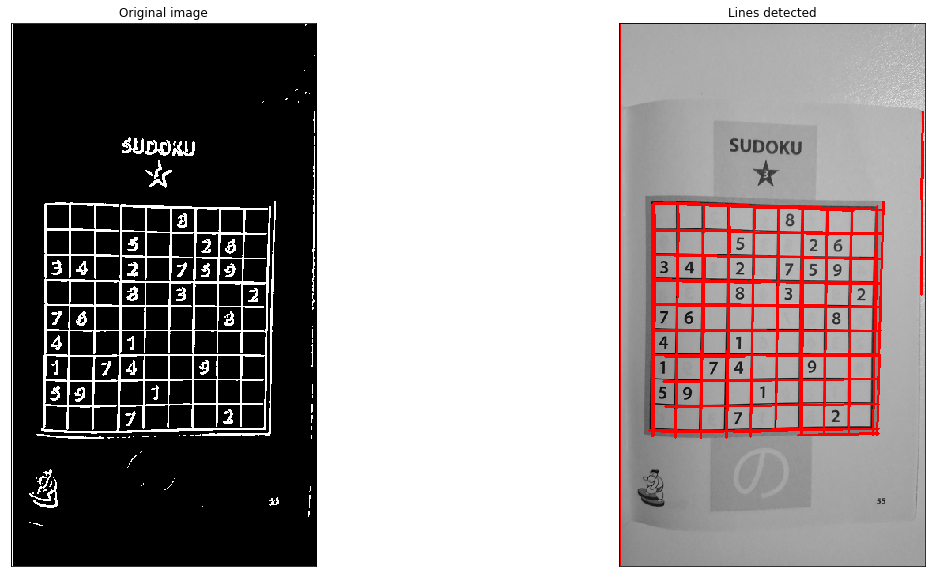

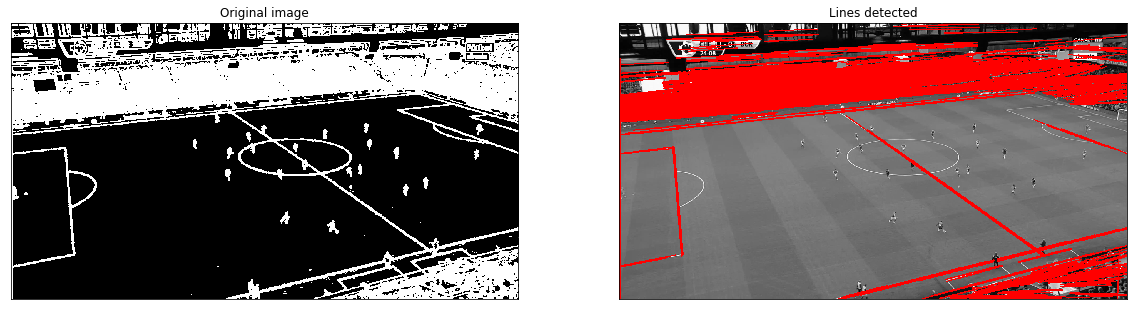

In [15]:
img_0 = load_gray_img("img/building.png")
img_1 = load_gray_img("img/sudoku.png", scale = 0.5)
img_2 = load_gray_img("img/soccer.png")

edge_img_0 = get_optimal_grads("building", "building", "Sobel")
edge_img_1 = get_optimal_grads("sudoku", "sudoku", "Sobel")
edge_img_2 = get_optimal_grads("soccer", "soccer","Beucher")


hough_probabilist_print(edge_img_0, img_0, 1, 0.015, 50, 30, 5)
hough_probabilist_print(edge_img_1, img_1, 1, 0.015, 50, 100, 5)
hough_probabilist_print(edge_img_2, img_2, 1, 0.03, 80, 110, 5)

## Line classification

The next and final step to this project is to extract the edges of the image that belong to a line. It is done rather easily in 4 steps : 
* First we extract the edges of the image and apply the Hough transform to get the lines in the image
* Secondly we draw these lines inside a empty image.
* We then convolve this image with the lines by a kernel of ones. This will "widen" the lines by the size of the kernel. It is very useful to extract lines that are more than 1 pixel wide in the image. A small kernel too small kernel will only take the pixels exactly on the lines, and a big one will take a lot of pixels in the neighbourhood of the lines.
* The final step is simply to compare pixel by pixel the extracted edges with the image with Hough's lines. For each pixel of an edge, we check if the pixel belong to a line in the image computed in the previous step. 

In [16]:
def update_lines(image_name = "building", edges_method = "Sobel", lines_method = "HoughProba", kernel_size = 3):    
    #Extract the Edges
    edges = get_optimal_grads(image_name, image_name, edges_method)
    
    #Create an empty image
    img_w_lines = np.zeros(edges.shape)

    #Get the lines of the images and print them on the empty image
    get_optimal_lines(image_name, edges, img_w_lines, lines_method)
    
    #Convolve the lines and run the pixel-wise comparison with the edges
    final, conv = get_edges_on_lines(edges, img_w_lines, kernel_size)
    
    tools.multiPlot(1, 4, 
        (edges, img_w_lines, conv, final),
        ('Edges', 'Lines detected', 'Convolved lines', 'Only Edges on Lines'),
        cmap_tuple=(cm.gray, cm.gray, cm.gray, cm.gray))
    
interact(update_lines,
        image_name = ["building", "sudoku", "soccer", "road", "pcb"],
        edges_method = ["Sobel", "Scharr", "Naive Gradient", "Beucher", "Canny", "Stacking"],
        lines_method = ["Hough", "HoughProba"], 
        kernel_size = (1, 7, 2))


interactive(children=(Dropdown(description='image_name', options=('building', 'sudoku', 'soccer', 'road', 'pcb…

<function __main__.update_lines(image_name='building', edges_method='Sobel', lines_method='HoughProba', kernel_size=3)>

For the images for which we didn't tune the parameters of the Hough transform, the parameters of the building image were used.

We can see that we have decent results for the sudoku, the soccer and the building for which we tuned the parameters. For the others images, since the edges are not well caputured, the lines are also not well defined. 